### Let's examine the effect of replacing Llama's dense attention with the hash attention kernel.

In [1]:
import torch
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype=torch.bfloat16,
                                             device_map="cuda:2")


In [2]:
conversation = [
    {"role": "user", "content": "Hello, how are you?"},
]
model_input = tokenizer.apply_chat_template(conversation, return_tensors="pt", add_generation_prompt = True).to(model.device)
response_tensor = model.generate(model_input, max_new_tokens = 20, temperature = 0.7)
tokenizer.decode(response_tensor[0][len(model_input[0]):])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


"I'm doing well, thank you for asking. I'm a large language model, so I don"

In [3]:
from torch import nn
from transformers.models.llama.modeling_llama import LlamaAttention, LlamaConfig, Cache, FlashAttentionKwargs, apply_rotary_pos_emb, repeat_kv
from typing import Tuple, Optional, Unpack
from tqdm import tqdm
from copy import deepcopy
from source.scfa_paper.scfa_wrapper import hash_sparse_attention

def vector_hash_fn(x: torch.Tensor, num_buckets: int, R: torch.Tensor) -> torch.Tensor:
    """
    x: (..., D)
    R: (D, b/2)
    """
    D = x.shape[-1]
    assert R.shape == (D, num_buckets // 2)
    return torch.argmax(torch.cat([x @ R, -x @ R], dim=-1), dim=-1)

def get_vector_hash(D: int, num_buckets: int, device: torch.device = "cpu", dtype: torch.dtype = torch.bfloat16) -> torch.Tensor:
    R = torch.randn(D, num_buckets // 2, device = device, dtype = dtype)
    return lambda x: vector_hash_fn(x, num_buckets, R)

def scfa_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)
    """
    B, H, N, D = q.shape
    if vector_hash is None:
        vector_hash = get_vector_hash(D = D, num_buckets = num_buckets, device = q.device)
    assert num_buckets % 2 == 0, "num_buckets must be even"
    q_hashes = vector_hash(q).to(torch.int32).transpose(1, 2).contiguous() # (B, N, H)
    k_hashes = vector_hash(k).to(torch.int32).transpose(1, 2).contiguous() # (B, N, H)
    assert q_hashes.max() < num_buckets, "q_hashes must be less than num_buckets"
    assert k_hashes.max() < num_buckets, "k_hashes must be less than num_buckets"
    assert q_hashes.min() >= 0, "q_hashes must be non-negative"
    assert k_hashes.min() >= 0, "k_hashes must be non-negative"
    scfa_q = q.transpose(1, 2).contiguous() # (B, N, H, D)
    scfa_k = k.transpose(1, 2).contiguous() # (B, N, H, D)
    scfa_v = v.transpose(1, 2).contiguous() # (B, N, H, D)
    return hash_sparse_attention(scfa_q, scfa_k, scfa_v, q_hashes, k_hashes, sm_scale).transpose(1, 2).contiguous()

def reference_hash_attn(q, k, v, num_buckets: int, sm_scale: float = 1.0, vector_hash = None):
    """
    q: (B, H, N, D)
    k: (B, H, N, D)
    v: (B, H, N, D)

    Note: This implementation sucks! It's just a sanity check.
    """
    assert num_buckets % 2 == 0, "num_buckets must be even"
    if vector_hash is None:
        vector_hash = get_vector_hash(D = q.shape[-1], num_buckets = num_buckets, device = q.device)
    B, H, N, D = q.shape
    q_hashes = vector_hash(q) # (B, H, N)
    k_hashes = vector_hash(k) # (B, H, N)
    out = torch.zeros_like(q)
    for i in range(num_buckets):
        for b in range(B):
            for h in range(H):
                q_mask = (q_hashes[b][h] == i) # (N)
                k_mask = (k_hashes[b][h] == i) # (N)
                q_indices = torch.nonzero(q_mask, as_tuple=False).squeeze() # (N)
                k_indices = torch.nonzero(k_mask, as_tuple=False).squeeze() # (N)
                if len(q_indices.shape) == 0 or len(k_indices.shape) == 0:
                    continue
                q_bucket = q[b, h, q_indices] # (N, D)
                k_bucket = k[b, h, k_indices] # (N, D)
                v_bucket = v[b, h, k_indices] # (N, D)
                attn_mask = q_indices.unsqueeze(-1) >= k_indices.unsqueeze(-2)
                attn_scores = torch.matmul(q_bucket, k_bucket.transpose(-2, -1)) * sm_scale
                attn_scores = attn_scores.masked_fill(~attn_mask, float("-inf"))
                attn = F.softmax(attn_scores, dim=-1)
                attn = attn.nan_to_num(0.0) # some cols will be totally masked out and softmax will produce NaNs
                # sns.heatmap(attn.cpu().numpy().squeeze(), annot = False, mask = ~attn_mask.cpu().numpy().squeeze())
                # plt.show()
                # return
                partial_prod = torch.matmul(attn, v_bucket)
                out[b, h, q_indices] += partial_prod.squeeze(0)
    return out

class HashAttention(LlamaAttention):
    def __init__(self, config: LlamaConfig, layer_idx: int, num_buckets: int, device):
        super().__init__(config, layer_idx)
        self.vector_hash = get_vector_hash(D = self.head_dim, num_buckets = num_buckets, device = device)
        self.num_buckets = num_buckets

    def forward(
        self,
        hidden_states: torch.Tensor, # (batch_size, seq_len, hidden_size)
        position_embeddings: Tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_value: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs: Unpack[FlashAttentionKwargs],
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        """
        Shapes:
        query_states: (batch_size, num_heads, seq_len, head_dim)
        key_states: (batch_size, num_heads, seq_len, head_dim)
        value_states: (batch_size, num_heads, seq_len, head_dim)
        """

        try:
            if past_key_value is not None:
                # sin and cos are specific to RoPE models; cache_position needed for the static cache
                cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
                key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

            attn_output = scfa_hash_attn(
                q = query_states,
                k = repeat_kv(key_states, self.num_key_value_groups),
                v = repeat_kv(value_states, self.num_key_value_groups),
                num_buckets = self.num_buckets,
                sm_scale = self.scaling,
                vector_hash = self.vector_hash,
            )

            attn_output = attn_output.reshape(*input_shape, -1).contiguous()
            attn_output = self.o_proj(attn_output)
        
        except Exception as e:
            print(query_states.shape, self.num_buckets)
            print(e)
        
        return attn_output, None
    
# Monkeypatch time
def monkeypatch(model, num_buckets: int, one_at_a_time: bool = False):
    n_modules_to_replace = len(list(filter(lambda x: isinstance(x, LlamaAttention), model.modules())))
    pbar = tqdm(total = n_modules_to_replace, desc = "Replacing attention modules")
    if one_at_a_time:
        pbar.disable = True    
    for name, module in model.named_modules():
        if isinstance(module, LlamaAttention):
            # Construct new module
            new_attn_module = HashAttention(config = module.config, layer_idx = module.layer_idx, num_buckets = num_buckets, device = model.device)
            new_attn_module.load_state_dict(module.state_dict())
            new_attn_module.to(model.device).to(torch.bfloat16)

            # Split full name to find parent module
            parent_module = model
            parent_name_parts = name.split('.')
            child_name = parent_name_parts[-1]

            if len(parent_name_parts) > 1:
                for part in parent_name_parts[:-1]:
                    if part.isdigit(): # Handles modules in nn.Sequential or nn.ModuleList
                        parent_module = parent_module[int(part)]
                    else:
                        parent_module = getattr(parent_module, part)

            setattr(parent_module, child_name, new_attn_module)
            if one_at_a_time:
                return
            pbar.update(1)

In [4]:
hash_model = deepcopy(model).to(model.device)
NUM_BUCKETS = 8
monkeypatch(hash_model, NUM_BUCKETS)
hash_model

Replacing attention modules:   0%|          | 0/16 [00:00<?, ?it/s]

Replacing attention modules: 100%|██████████| 16/16 [00:00<00:00, 25.30it/s]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): HashAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

In [5]:
conversation = [
    {"role": "user", "content": "Hello, how are you?"},
]
model_input = tokenizer.apply_chat_template(conversation, return_tensors="pt", add_generation_prompt = True).to(model.device)
response_tensor = hash_model.generate(model_input, max_new_tokens = 20)
print(tokenizer.decode(response_tensor[0][len(model_input[0]):]))

del hash_model
torch.cuda.empty_cache()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  the end-of- (I. (and the United Statesville. ( }

I hope for


### Tuning

We just initialized a number of random projections, so it's very likely that our model is now totally nonfunctional. Let's attempt to finetune it back to normalcy.

In [6]:
%env CUDA_LAUNCH_BLOCKING=1
import datasets

fineweb_dataset = datasets.load_dataset("HuggingFaceFW/fineweb", "sample-10BT", split="train", streaming=True)
hash_model = deepcopy(model).to(model.device)
NUM_BUCKETS = 8
tokenizer.pad_token = tokenizer.eos_token

total_steps_processed = 0
n_modules_to_replace = len(list(filter(lambda x: isinstance(x, LlamaAttention), hash_model.modules())))
while n_modules_to_replace > 0:
    print(f"{n_modules_to_replace} LlamaAttention modules remaining")
    # Patch llama attention modules into hash attention modules, one at a time
    monkeypatch(hash_model, NUM_BUCKETS, one_at_a_time = True)
    n_modules_to_replace -= 1
    hash_model.train()

    # Freeze all but the hash attention modules
    for p in hash_model.parameters():
        p.requires_grad = False
    for name, module in hash_model.named_modules():
        if isinstance(module, HashAttention):
            for param in module.parameters():
                param.requires_grad = True

    optimizer = torch.optim.AdamW(hash_model.parameters(), lr=1e-5)
    hash_model.train()

    # Training loop parameters
    num_steps = 1e3
    max_length = 512
    ema_alpha = 0.05  # EMA smoothing factor

    step = 0
    ema_loss = None
    ema_perplexity = None

    # Use streaming dataset with tqdm
    with tqdm(total=num_steps, desc="Training") as pbar:
        for example in fineweb_dataset:
            if step >= num_steps:
                total_steps_processed += step
                fineweb_dataset = fineweb_dataset.skip(total_steps_processed) # continue from where we left off
                break
                
            text = example['text']
            inputs = tokenizer(text, return_tensors="pt", max_length=max_length, 
                            truncation=True, padding=True)
            inputs = {k: v.to(hash_model.device) for k, v in inputs.items()}
            
            # Forward pass
            outputs = hash_model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            perplexity = torch.exp(loss).item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update EMA metrics
            current_loss = loss.item()
            if ema_loss is None:
                ema_loss = current_loss
                ema_perplexity = perplexity
            else:
                ema_loss = ema_alpha * current_loss + (1 - ema_alpha) * ema_loss
                ema_perplexity = ema_alpha * perplexity + (1 - ema_alpha) * ema_perplexity
            
            step += 1
            
            # Update pbar
            pbar.set_description(f"Training - Loss: {ema_loss:.4f}, PPL: {ema_perplexity:.2f}")
            pbar.update(1)

env: CUDA_LAUNCH_BLOCKING=1


Resolving data files:   0%|          | 0/25868 [00:00<?, ?it/s]

16 LlamaAttention modules remaining


Training - Loss: 4.2322, PPL: 87.69: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.34it/s]


15 LlamaAttention modules remaining


Training - Loss: 4.0662, PPL: 80.87: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.74it/s]


14 LlamaAttention modules remaining


Training - Loss: 3.5411, PPL: 38.16: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.77it/s]


13 LlamaAttention modules remaining


Training - Loss: 3.7424, PPL: 51.86: 100%|██████████| 1000/1000.0 [00:52<00:00, 18.90it/s]


12 LlamaAttention modules remaining


Training - Loss: 3.5589, PPL: 40.85: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.24it/s]


11 LlamaAttention modules remaining


Training - Loss: 3.5845, PPL: 39.47: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.29it/s]


10 LlamaAttention modules remaining


Training - Loss: 3.5058, PPL: 40.73: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.72it/s]


9 LlamaAttention modules remaining


Training - Loss: 3.4587, PPL: 37.66: 100%|██████████| 1000/1000.0 [00:52<00:00, 18.98it/s]


8 LlamaAttention modules remaining


Training - Loss: 3.6155, PPL: 42.73: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.34it/s]


7 LlamaAttention modules remaining


Training - Loss: 3.5397, PPL: 42.34: 100%|██████████| 1000/1000.0 [00:55<00:00, 18.11it/s]


6 LlamaAttention modules remaining


Training - Loss: 3.4998, PPL: 37.88: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.19it/s]


5 LlamaAttention modules remaining


Training - Loss: 3.6101, PPL: 43.43: 100%|██████████| 1000/1000.0 [00:55<00:00, 18.10it/s]


4 LlamaAttention modules remaining


Training - Loss: 3.5785, PPL: 43.95: 100%|██████████| 1000/1000.0 [00:55<00:00, 17.94it/s]


3 LlamaAttention modules remaining


Training - Loss: 3.4386, PPL: 36.56: 100%|██████████| 1000/1000.0 [00:56<00:00, 17.70it/s]


2 LlamaAttention modules remaining


Training - Loss: 3.7887, PPL: 58.24: 100%|██████████| 1000/1000.0 [00:55<00:00, 18.06it/s]


1 LlamaAttention modules remaining


Training - Loss: 3.5101, PPL: 40.33: 100%|██████████| 1000/1000.0 [00:56<00:00, 17.80it/s]


## Evaluations

Let's evaluate the performance of our newly hash-ified model on a few tasks.

In [ ]:
# Compare responses from original model vs hash attention model
import pandas as pd
from IPython.display import display, HTML

# Define common prompts to test
test_prompts = [
    "Hello, how are you?",
    "What is the capital of France?",
    "Explain quantum computing in simple terms.",
    "Write a short poem about nature.",
    "What are the benefits of exercise?",
]

# Generate responses from both models
comparison_data = []

for prompt in test_prompts:
    conversation = [{"role": "user", "content": prompt}]
    model_input = tokenizer.apply_chat_template(conversation, return_tensors="pt", add_generation_prompt=True).to(model.device)
    
    # Generate response from original model
    with torch.no_grad():
        original_response = model.generate(model_input, max_new_tokens=50, do_sample=False, pad_token_id=tokenizer.eos_token_id)
        original_text = tokenizer.decode(original_response[0][len(model_input[0]):], skip_special_tokens=True)
    
    # Generate response from hash attention model
    with torch.no_grad():
        hash_response = hash_model.generate(model_input, max_new_tokens=50, do_sample=False, pad_token_id=tokenizer.eos_token_id)
        hash_text = tokenizer.decode(hash_response[0][len(model_input[0]):], skip_special_tokens=True)
    
    comparison_data.append({
        'Prompt': prompt,
        'Original Model': original_text.strip(),
        'Hash Attention Model': hash_text.strip()
    })

# Create and display comparison table
df = pd.DataFrame(comparison_data)
df.index = df.index + 1  # Start index from 1

# Style the dataframe for better display
styled_df = df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
    'max-width': '300px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]}
])
# Convert dataframe to HTML with markdown rendering
import markdown

def render_markdown_table(df):
    html_parts = ['<table style="border-collapse: collapse; width: 100%;">']
    
    # Add header
    html_parts.append('<thead><tr style="background-color: #f0f0f0;">')
    for col in df.columns:
        html_parts.append(f'<th style="border: 1px solid #ddd; padding: 8px; font-weight: bold; text-align: left;">{col}</th>')
    html_parts.append('</tr></thead>')
    
    # Add body
    html_parts.append('<tbody>')
    for idx, row in df.iterrows():
        html_parts.append('<tr>')
        for col in df.columns:
            cell_content = str(row[col])
            # Convert markdown to HTML for each cell
            rendered_content = markdown.markdown(cell_content)
            html_parts.append(f'<td style="border: 1px solid #ddd; padding: 8px; text-align: left; max-width: 300px; white-space: pre-wrap;">{rendered_content}</td>')
        html_parts.append('</tr>')
    html_parts.append('</tbody>')
    html_parts.append('</table>')
    
    return ''.join(html_parts)
    
# Render the table with markdown support
table_html = render_markdown_table(df)

display(HTML(table_html))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


### Perplexity Metrics

In [ ]:
import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load a slice of the FineWeb dataset
fineweb_dataset = datasets.load_dataset("HuggingFaceFW/fineweb", "sample-10BT", split="train", streaming=True)
fineweb_sample = fineweb_dataset.take(100) 
tokenizer.pad_token = tokenizer.eos_token

# Function to compute KL divergence between original and hash model
def compute_fineweb_metrics(original_model, hash_model, tokenizer, texts, max_length=512):
    import torch.nn.functional as F
    
    kl_divergences = []
    original_perplexities = []
    hash_perplexities = []
    
    for text in tqdm(texts):
        # Tokenize the text
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding=True)
        inputs = {k: v.to(original_model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            # Get logits from both models
            original_outputs = original_model(**inputs)
            hash_outputs = hash_model(**inputs)
            
            original_logits = original_outputs.logits
            hash_logits = hash_outputs.logits
            
            # Convert to probabilities
            original_probs = F.softmax(original_logits, dim=-1)
            hash_probs = F.softmax(hash_logits, dim=-1)
            
            # Compute KL divergence: KL(original || hash)
            kl_div = F.kl_div(hash_probs.log(), original_probs, reduction='batchmean')
            kl_divergences.append(kl_div.item())
            
            # Compute perplexities
            # Shift logits and labels for next token prediction
            shift_logits_original = original_logits[..., :-1, :].contiguous()
            shift_logits_hash = hash_logits[..., :-1, :].contiguous()
            shift_labels = inputs['input_ids'][..., 1:].contiguous()
            
            # Compute cross entropy loss
            original_loss = F.cross_entropy(shift_logits_original.view(-1, shift_logits_original.size(-1)), 
                                          shift_labels.view(-1), reduction='mean')
            hash_loss = F.cross_entropy(shift_logits_hash.view(-1, shift_logits_hash.size(-1)), 
                                      shift_labels.view(-1), reduction='mean')
            
            # Convert loss to perplexity
            original_perplexity = torch.exp(original_loss).item()
            hash_perplexity = torch.exp(hash_loss).item()
            
            original_perplexities.append(original_perplexity)
            hash_perplexities.append(hash_perplexity)
    
    return {
        'kl_divergences': kl_divergences,
        'original_perplexities': original_perplexities,
        'hash_perplexities': hash_perplexities
    }
# Extract texts from the dataset
texts = [sample['text'] for sample in fineweb_sample]

print("Computing KL divergences between flash and hash attention models...")
kl_divs = compute_fineweb_metrics(model, hash_model, tokenizer, texts)

# Create the bar plot
ax = sns.barplot(x=["KL Divergence", "Original Perplexity", "Hash Perplexity"], 
                 y=[np.mean(kl_divs['kl_divergences']), 
                    np.mean(kl_divs['original_perplexities']), 
                    np.mean(kl_divs['hash_perplexities'])])

# Add value labels on top of each bar
for i, v in enumerate([np.mean(kl_divs['kl_divergences']), 
                       np.mean(kl_divs['original_perplexities']), 
                       np.mean(kl_divs['hash_perplexities'])]):
    ax.text(i, v + v*0.01, f'{v:.2f}', ha='center', va='bottom')

plt.title('Comparison of KL Divergence and Perplexities')
plt.show()

### Speed Metrics


Benchmarking sequence length: 256
Benchmarking original model forward pass...
Benchmarking original model backward pass...
Benchmarking hash model forward pass...
Benchmarking hash model backward pass...
Original model forward: 0.0153s ± 0.0001s
Original model backward: 0.0464s ± 0.0033s
Hash model forward: 0.0147s ± 0.0000s
Hash model backward: 0.0335s ± 0.0014s
Forward speedup: 1.04x
Backward speedup: 1.39x

Benchmarking sequence length: 512
Benchmarking original model forward pass...
Benchmarking original model backward pass...
Benchmarking hash model forward pass...
Benchmarking hash model backward pass...
Original model forward: 0.0255s ± 0.0001s
Original model backward: 0.0801s ± 0.0003s
Hash model forward: 0.0263s ± 0.0001s
Hash model backward: 0.0567s ± 0.0001s
Forward speedup: 0.97x
Backward speedup: 1.41x

Benchmarking sequence length: 1024
Benchmarking original model forward pass...
Benchmarking original model backward pass...
Benchmarking hash model forward pass...
Benchma

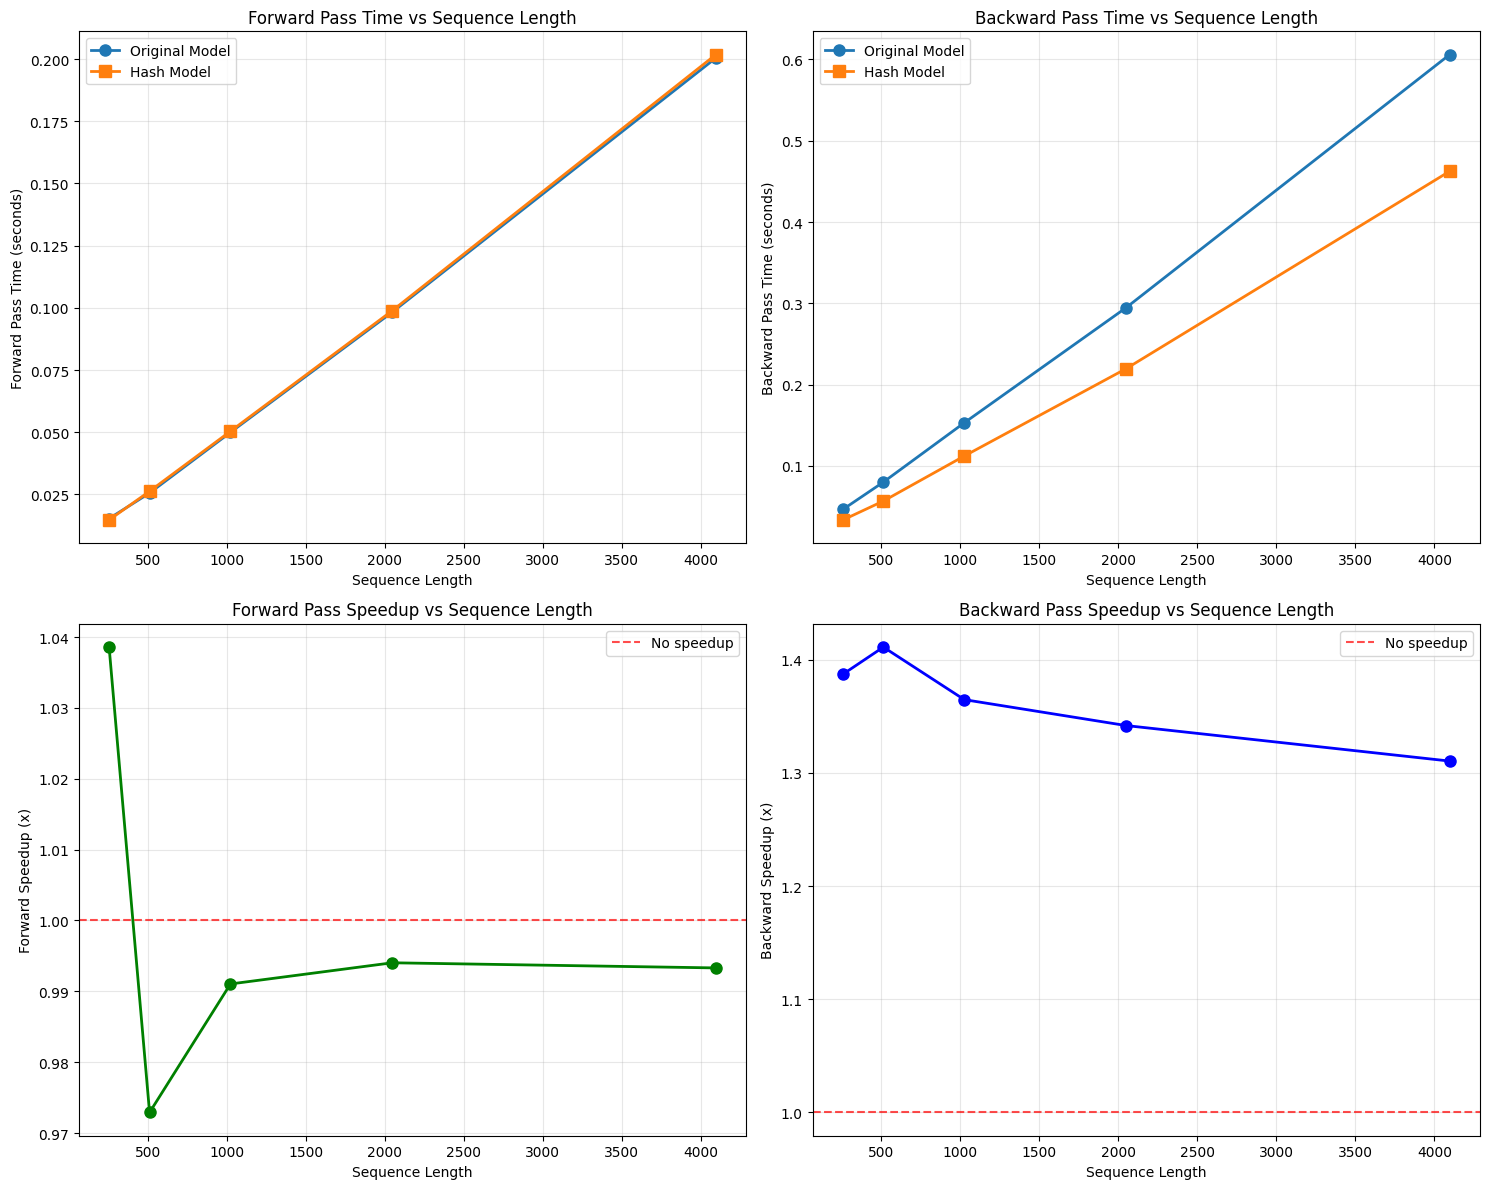

In [6]:
import time
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = model.device
torch.cuda.set_device(device)
def benchmark_models(original_model, hash_model, tokenizer, seq_lengths=[256, 512, 1024, 2048, 4096], num_warmup=3, num_runs=10):
    """Benchmark both models at different sequence lengths for forward and backward passes"""
    results = {}
    
    # Set models to train mode for backward pass benchmarking
    original_model.train()
    hash_model.train()
    
    for seq_len in seq_lengths:
        print(f"\nBenchmarking sequence length: {seq_len}")
        
        # Generate random sequences for this length
        random_sequences = []
        for _ in range(num_warmup + num_runs):
            # Generate random token IDs (avoiding special tokens)
            random_ids = [random.randint(1, tokenizer.vocab_size - 1000) for _ in range(seq_len)]
            random_sequences.append(random_ids)
        
        # Benchmark original model - Forward pass
        original_forward_times = []
        print("Benchmarking original model forward pass...")
        
        with torch.no_grad():
            # Warmup runs
            for i in range(num_warmup):
                input_ids = torch.tensor([random_sequences[i]], device=device)
                _ = original_model(input_ids)
            
            # Actual benchmark runs
            for i in range(num_warmup, num_warmup + num_runs):
                input_ids = torch.tensor([random_sequences[i]], device=device)
                
                torch.cuda.synchronize()
                start_time = time.time()
                _ = original_model(input_ids)
                torch.cuda.synchronize()
                end_time = time.time()
                
                original_forward_times.append(end_time - start_time)
        
        # Benchmark original model - Backward pass
        original_backward_times = []
        print("Benchmarking original model backward pass...")
        
        # Warmup runs
        for i in range(num_warmup):
            input_ids = torch.tensor([random_sequences[i]], device=device)
            outputs = original_model(input_ids)
            loss = outputs.logits.sum()
            loss.backward()
            original_model.zero_grad()
        
        # Actual benchmark runs
        for i in range(num_warmup, num_warmup + num_runs):
            input_ids = torch.tensor([random_sequences[i]], device=device)
            
            torch.cuda.synchronize()
            start_time = time.time()
            outputs = original_model(input_ids)
            loss = outputs.logits.sum()
            loss.backward()
            torch.cuda.synchronize()
            end_time = time.time()
            
            original_backward_times.append(end_time - start_time)
            original_model.zero_grad()
        
        # Benchmark hash model - Forward pass
        hash_forward_times = []
        print("Benchmarking hash model forward pass...")
        
        with torch.no_grad():
            # Warmup runs
            for i in range(num_warmup):
                input_ids = torch.tensor([random_sequences[i]], device=device)
                _ = hash_model.forward(input_ids)
            
            # Actual benchmark runs
            for i in range(num_warmup, num_warmup + num_runs):
                input_ids = torch.tensor([random_sequences[i]], device=device)
                
                torch.cuda.synchronize()
                start_time = time.time()
                _ = hash_model.forward(input_ids)
                torch.cuda.synchronize()
                end_time = time.time()
                
                hash_forward_times.append(end_time - start_time)
        
        # Benchmark hash model - Backward pass
        hash_backward_times = []
        print("Benchmarking hash model backward pass...")
        
        # Warmup runs
        for i in range(num_warmup):
            input_ids = torch.tensor([random_sequences[i]], device=device)
            outputs = hash_model.forward(input_ids)
            loss = outputs.logits.sum()
            loss.backward()
            hash_model.zero_grad()
        
        # Actual benchmark runs
        for i in range(num_warmup, num_warmup + num_runs):
            input_ids = torch.tensor([random_sequences[i]], device=device)
            
            torch.cuda.synchronize()
            start_time = time.time()
            outputs = hash_model.forward(input_ids)
            loss = outputs.logits.sum()
            loss.backward()
            torch.cuda.synchronize()
            end_time = time.time()
            
            hash_backward_times.append(end_time - start_time)
            hash_model.zero_grad()
        
        results[seq_len] = {
            'original_forward_times': original_forward_times,
            'original_backward_times': original_backward_times,
            'hash_forward_times': hash_forward_times,
            'hash_backward_times': hash_backward_times,
            'original_forward_mean': np.mean(original_forward_times),
            'original_backward_mean': np.mean(original_backward_times),
            'hash_forward_mean': np.mean(hash_forward_times),
            'hash_backward_mean': np.mean(hash_backward_times),
            'forward_speedup': np.mean(original_forward_times) / np.mean(hash_forward_times),
            'backward_speedup': np.mean(original_backward_times) / np.mean(hash_backward_times)
        }
        
        print(f"Original model forward: {np.mean(original_forward_times):.4f}s ± {np.std(original_forward_times):.4f}s")
        print(f"Original model backward: {np.mean(original_backward_times):.4f}s ± {np.std(original_backward_times):.4f}s")
        print(f"Hash model forward: {np.mean(hash_forward_times):.4f}s ± {np.std(hash_forward_times):.4f}s")
        print(f"Hash model backward: {np.mean(hash_backward_times):.4f}s ± {np.std(hash_backward_times):.4f}s")
        print(f"Forward speedup: {results[seq_len]['forward_speedup']:.2f}x")
        print(f"Backward speedup: {results[seq_len]['backward_speedup']:.2f}x")
    
    return results
# Run benchmarks
benchmark_results = benchmark_models(model, hash_model, tokenizer)

# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

seq_lengths = list(benchmark_results.keys())
original_forward_times = [benchmark_results[seq_len]['original_forward_mean'] for seq_len in seq_lengths]
original_backward_times = [benchmark_results[seq_len]['original_backward_mean'] for seq_len in seq_lengths]
hash_forward_times = [benchmark_results[seq_len]['hash_forward_mean'] for seq_len in seq_lengths]
hash_backward_times = [benchmark_results[seq_len]['hash_backward_mean'] for seq_len in seq_lengths]
forward_speedups = [benchmark_results[seq_len]['forward_speedup'] for seq_len in seq_lengths]
backward_speedups = [benchmark_results[seq_len]['backward_speedup'] for seq_len in seq_lengths]

# Plot forward pass times
ax1.plot(seq_lengths, original_forward_times, 'o-', label='Original Model', linewidth=2, markersize=8)
ax1.plot(seq_lengths, hash_forward_times, 's-', label='Hash Model', linewidth=2, markersize=8)
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Forward Pass Time (seconds)')
ax1.set_title('Forward Pass Time vs Sequence Length')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot backward pass times
ax2.plot(seq_lengths, original_backward_times, 'o-', label='Original Model', linewidth=2, markersize=8)
ax2.plot(seq_lengths, hash_backward_times, 's-', label='Hash Model', linewidth=2, markersize=8)
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Backward Pass Time (seconds)')
ax2.set_title('Backward Pass Time vs Sequence Length')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot forward speedup
ax3.plot(seq_lengths, forward_speedups, 'o-', color='green', linewidth=2, markersize=8)
ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')
ax3.set_xlabel('Sequence Length')
ax3.set_ylabel('Forward Speedup (x)')
ax3.set_title('Forward Pass Speedup vs Sequence Length')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot backward speedup
ax4.plot(seq_lengths, backward_speedups, 'o-', color='blue', linewidth=2, markersize=8)
ax4.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')
ax4.set_xlabel('Sequence Length')
ax4.set_ylabel('Backward Speedup (x)')
ax4.set_title('Backward Pass Speedup vs Sequence Length')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()